## T cell–focused analysis: PR vs SD in NSCLC immunotherapy

After global cell-type annotation and cluster-level comparisons, we focused on the T-cell compartment to investigate functional differences associated with clinical response (RECIST PR vs SD).

### T-cell subset and functional programs
T cells were identified based on cluster-level annotation and subset from the full scRNA-seq dataset. Within this subset, three functional programs were scored at the single-cell level:
- **Naive/Memory program** (e.g. *IL7R, CCR7, TCF7, LTB*)
- **Cytotoxic program** (e.g. *NKG7, PRF1, GZMB, IFNG*)
- **Checkpoint/Exhaustion program** (e.g. *PDCD1, CTLA4, TIGIT, LAG3*)

Each cell was assigned a dominant functional state based on the highest program score.

### Distribution of dominant T-cell states by clinical response
Comparison of dominant functional states between PR and SD patients revealed distinct T-cell profiles:

- **Partial Responders (PR)** showed an enrichment in **cytotoxic T cells** (~39%), consistent with effective antitumor immune engagement.
- **Stable Disease (SD)** patients were dominated by **naive/memory T cells** (~50%), suggesting a less activated immune state.
- **Checkpoint/Exhaustion states** were present at comparable levels in both groups (~26%), indicating regulated activation rather than terminal exhaustion.

These trends were consistently observed across dotplots and violin plots of program scores.

### Zoom within T cells: CD8-like vs CD4-like states
To further refine T-cell heterogeneity, we compared CD8-like and CD4-like transcriptional programs:
- **CD8-like program** (e.g. *CD8A, CD8B, NKG7, PRF1*)
- **CD4-like / naive-memory program** (e.g. *IL7R, CCR7, LTB, TCF7*)

This analysis showed:
- **PR patients** enriched in **CD8-like cytotoxic T cells** (~54%)
- **SD patients** enriched in **CD4-like naive/memory T cells** (~65%)

### Summary
Across multiple complementary analyses, PR patients consistently display a T-cell compartment skewed toward cytotoxic CD8-like states, whereas SD patients show predominance of naive/memory CD4-like T cells. This convergence supports a biologically coherent association between T-cell functional polarization and response to immunotherapy.

These single-cell findings provide a strong basis for integration with bulk RNA-seq data to assess whether similar immune signatures are detectable at the tissue level.

In [2]:
# Project setup — set working directory to project root

# Step — Move working directory to project root

import os
os.chdir("..")
print("CWD after chdir:", os.getcwd())

CWD after chdir: c:\Users\yasmi\OneDrive\Desktop\Mini-Projets\scRNA_LUAD_Immunotherapy


In [13]:
import scanpy as sc
sc.settings.figdir = "Results/Figures"

In [6]:
# Step — Automated cell-type / state labeling from top markers (dictionary scoring)

import pandas as pd
from collections import defaultdict

# ---- 1) Load top markers (top 50 per cluster already) ----
pr_path = "Results/top50_markers_PRclusters_ratio1.5.csv"
sd_path = "Results/top50_markers_SDclusters_ratio1.5.csv"

PR = pd.read_csv(pr_path)
SD = pd.read_csv(sd_path)

# Normalize gene symbols to uppercase (important)
PR["names"] = PR["names"].astype(str).str.upper()
SD["names"] = SD["names"].astype(str).str.upper()

# ---- 2) Marker dictionary (edit freely over time) ----
marker_sets = {
    # Major lineages
    "T_cells": {"TRAC","TRBC1","TRBC2","CD3D","CD3E","CD3G","LTB","IL32","CD2","CD7","LCK","TRAT1"},
    "NK_cells": {"NKG7","GNLY","PRF1","GZMB","GZMH","KLRD1","FCER1G","TYROBP","TRDC","TRGC1","TRGC2"},
    "B_cells": {"MS4A1","CD79A","CD79B","CD74","HLA-DRA","HLA-DRB1","CD19","BANK1","CD22","VPREB3","PAX5"},
    "Plasma_cells": {"MZB1","JCHAIN","SDC1","PRDM1","XBP1","FKBP11","DERL3","TENT5C"},
    "Myeloid": {"LYZ","LST1","S100A8","S100A9","FCN1","CTSS","CTSD","AIF1","TYROBP","FCGR3A","MS4A7","LGALS3"},
    "Macrophage_M2_TAM": {"MRC1","APOC1","APOC2","C1QA","C1QB","C1QC","CD163","MSR1","MARCO","GPNMB"},
    "Dendritic": {"FCER1A","CLEC10A","CST3","ITGAX","LILRA4","GZMB","IRF7"},
    "Epithelial_tumor": {"EPCAM","KRT8","KRT18","KRT19","KRT7","MUC1","TACSTD2","ALDH1A1","EHF"},
    "Endothelial": {"PECAM1","VWF","KDR","ESAM","RAMP2"},
    "Fibroblast_stromal": {"COL1A1","COL1A2","DCN","LUM","TAGLN","ACTA2","VIM"},

    # T cell states (overlapping labels are expected)
    "T_naive_memory": {"IL7R","CCR7","TCF7","LEF1","LST1","MAL","SELL","KLF2","BACH2"},
    "T_cytotoxic": {"CD8A","CD8B","GZMB","PRF1","NKG7","GNLY","CTSW","IFNG","CCL4","CCL5"},
    "T_activation": {"CD69","ICOS","TNFRSF4","TNFRSF18","JUN","JUNB","FOS","FOSB"},
    "T_exhaustion": {"PDCD1","CTLA4","TIGIT","LAG3","HAVCR2","TOX","CXCL13"},
    "Treg": {"FOXP3","IL2RA","IKZF2","IKZF4","CTLA4","TNFRSF18"},

    # Proliferation
    "Cycling": {"MKI67","TOP2A","CENPF","ASPM","TYMS","HMGB2","TUBB","STMN1"},
}

# ---- 3) Scoring function ----
def score_cluster_genes(gene_list, marker_sets):
    genes = set([g for g in gene_list if g and g != "NAN"])
    scores = {}
    for label, mset in marker_sets.items():
        overlap = genes.intersection(mset)
        scores[label] = len(overlap)
    return scores

def summarize_scores(scores_dict, top_k=4):
    # returns list of (label,score) sorted
    return sorted(scores_dict.items(), key=lambda x: x[1], reverse=True)[:top_k]

# ---- 4) Apply scoring per cluster ----
def annotate(df, group_col="group", gene_col="names"):
    out_rows = []
    for grp, sub in df.groupby(group_col):
        genes = sub[gene_col].tolist()
        scores = score_cluster_genes(genes, marker_sets)
        top = summarize_scores(scores, top_k=6)

        # simple primary label = best major lineage among a shortlist
        major_lineages = ["T_cells","NK_cells","B_cells","Plasma_cells","Myeloid","Macrophage_M2_TAM","Dendritic",
                        "Epithelial_tumor","Endothelial","Fibroblast_stromal","Cycling"]
        best_major = max(major_lineages, key=lambda k: scores.get(k,0))
        best_major_score = scores.get(best_major, 0)

        # secondary (states) if T-related
        t_states = ["T_naive_memory","T_cytotoxic","T_exhaustion","T_activation","Treg"]
        best_t_state = max(t_states, key=lambda k: scores.get(k,0))
        best_t_state_score = scores.get(best_t_state, 0)

        out_rows.append({
            "cluster": str(grp),
            "n_top_genes_used": len(set(sub[gene_col])),
            "best_major": best_major,
            "best_major_score": best_major_score,
            "best_T_state": best_t_state,
            "best_T_state_score": best_t_state_score,
            "top_labels": "; ".join([f"{k}:{v}" for k,v in top])
        })
    return pd.DataFrame(out_rows).sort_values("cluster", key=lambda s: s.astype(int))

PR_annot = annotate(PR)
SD_annot = annotate(SD)

display(PR_annot)
display(SD_annot)

PR_annot.to_csv("Results/PR_clusters_auto_annotation.csv", index=False)
SD_annot.to_csv("Results/SD_clusters_auto_annotation.csv", index=False)

print("Saved:")
print(" - Results/PR_clusters_auto_annotation.csv")
print(" - Results/SD_clusters_auto_annotation.csv")

,cluster,n_top_genes_used,best_major,best_major_score,best_T_state,best_T_state_score,top_labels
0,0,50,T_cells,12,T_naive_memory,5,T_cells:12; T_naive_memory:5; T_activation:3; ...
1,1,50,T_cells,10,T_cytotoxic,10,T_cells:10; T_cytotoxic:10; NK_cells:7; T_exha...
2,2,50,B_cells,11,T_naive_memory,2,B_cells:11; T_naive_memory:2; T_cells:1; T_act...
3,3,50,T_cells,10,T_cytotoxic,4,T_cells:10; T_cytotoxic:4; NK_cells:1; T_activ...
4,10,50,T_cells,11,Treg,5,T_cells:11; Treg:5; T_naive_memory:2; T_activa...
5,12,50,Myeloid,8,T_naive_memory,0,Myeloid:8; Macrophage_M2_TAM:2; NK_cells:1; B_...
6,13,50,Plasma_cells,7,T_activation,1,Plasma_cells:7; B_cells:2; T_activation:1; T_c...
7,16,50,Epithelial_tumor,7,T_naive_memory,0,Epithelial_tumor:7; Myeloid:1; T_cells:0; NK_c...
8,17,50,T_cells,10,T_cytotoxic,8,T_cells:10; T_cytotoxic:8; NK_cells:5; T_exhau...


,cluster,n_top_genes_used,best_major,best_major_score,best_T_state,best_T_state_score,top_labels
0,4,50,Macrophage_M2_TAM,9,T_naive_memory,0,Macrophage_M2_TAM:9; Myeloid:6; B_cells:2; NK_...
1,6,50,Myeloid,4,T_activation,2,Myeloid:4; T_activation:2; NK_cells:1; T_naive...
2,8,50,Epithelial_tumor,5,T_naive_memory,0,Epithelial_tumor:5; Plasma_cells:1; T_cells:0;...
3,15,50,Epithelial_tumor,7,T_naive_memory,0,Epithelial_tumor:7; Plasma_cells:1; T_cells:0;...
4,18,50,Fibroblast_stromal,6,T_naive_memory,0,Fibroblast_stromal:6; T_cells:0; NK_cells:0; B...
5,20,50,T_cells,0,T_naive_memory,0,T_cells:0; NK_cells:0; B_cells:0; Plasma_cells...
6,21,50,T_cells,6,T_naive_memory,1,T_cells:6; Epithelial_tumor:1; T_naive_memory:...


Saved:
 - Results/PR_clusters_auto_annotation.csv
 - Results/SD_clusters_auto_annotation.csv


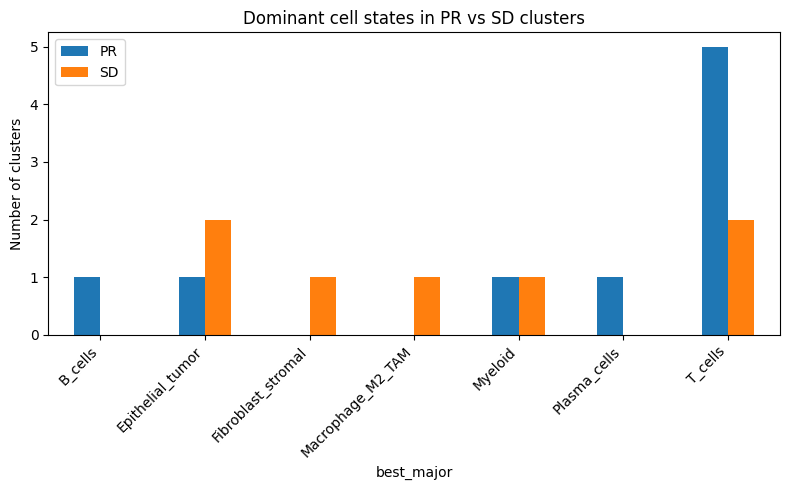

In [9]:
# Barplot of dominant cell states in PR vs SD clusters

import pandas as pd
import matplotlib.pyplot as plt

# Load annotations
pr = pd.read_csv("Results/PR_clusters_auto_annotation.csv")
sd = pd.read_csv("Results/SD_clusters_auto_annotation.csv")

# Count dominant major lineages
pr_counts = pr["best_major"].value_counts()
sd_counts = sd["best_major"].value_counts()

# Combine into one DataFrame
df = pd.DataFrame({
    "PR": pr_counts,
    "SD": sd_counts
}).fillna(0)

# Plot
df.plot(kind="bar", figsize=(8,5))
plt.ylabel("Number of clusters")
plt.title("Dominant cell states in PR vs SD clusters")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.savefig("Results/Figures/PR_vs_SD_dominant_cell_states_barplot.png", dpi=300, bbox_inches="tight")
plt.show()

T-cell clusters: ['0', '1', '10', '17', '20', '21', '3']
T-cell subset shape (cells, genes): (15038, 2000)
RECIST counts in T cells:
 RECIST
PR    11550
SD     3488
Name: count, dtype: int64


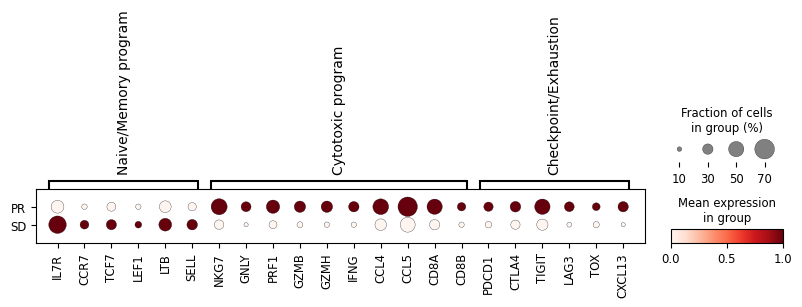

In [14]:
# T-cell focus — subset T cells and compare PR vs SD functional states (dotplot) + save

import scanpy as sc
import pandas as pd

# Load annotated full object
adata = sc.read_h5ad("Data/adata_scRNA_40k_umap_leiden_meta.h5ad")

# Load heuristic annotation tables (cluster-level)
pr_annot = pd.read_csv("Results/PR_clusters_auto_annotation.csv")
sd_annot = pd.read_csv("Results/SD_clusters_auto_annotation.csv")
annot = pd.concat([pr_annot, sd_annot], ignore_index=True)

# Keep clusters labeled as T_cells (you can later expand to NK if desired)
t_clusters = sorted(set(annot.loc[annot["best_major"] == "T_cells", "cluster"].astype(str)))
print("T-cell clusters:", t_clusters)

# Subset T cells
adata_t = adata[adata.obs["leiden"].astype(str).isin(t_clusters)].copy()
print("T-cell subset shape (cells, genes):", adata_t.shape)
print("RECIST counts in T cells:\n", adata_t.obs["RECIST"].value_counts())

# Gene sets for state scoring (edit later if needed)
naive_memory = ["IL7R","CCR7","TCF7","LEF1","LTB","SELL"]
cytotoxic   = ["NKG7","GNLY","PRF1","GZMB","GZMH","IFNG","CCL4","CCL5","CD8A","CD8B"]
exhaustion  = ["PDCD1","CTLA4","TIGIT","LAG3","TOX","CXCL13"]

# Score genes (adds columns to adata_t.obs)
sc.tl.score_genes(adata_t, gene_list=naive_memory, score_name="score_naive_memory")
sc.tl.score_genes(adata_t, gene_list=cytotoxic,   score_name="score_cytotoxic")
sc.tl.score_genes(adata_t, gene_list=exhaustion,  score_name="score_exhaustion")

# Dotplot by clinical group
sc.pl.dotplot(
    adata_t,
    var_names={
        "Naive/Memory program": naive_memory,
        "Cytotoxic program": cytotoxic,
        "Checkpoint/Exhaustion": exhaustion,
    },
    groupby="RECIST",
    standard_scale="var",
    save="_Tcells_PR_vs_SD_state_dotplot.png"
)

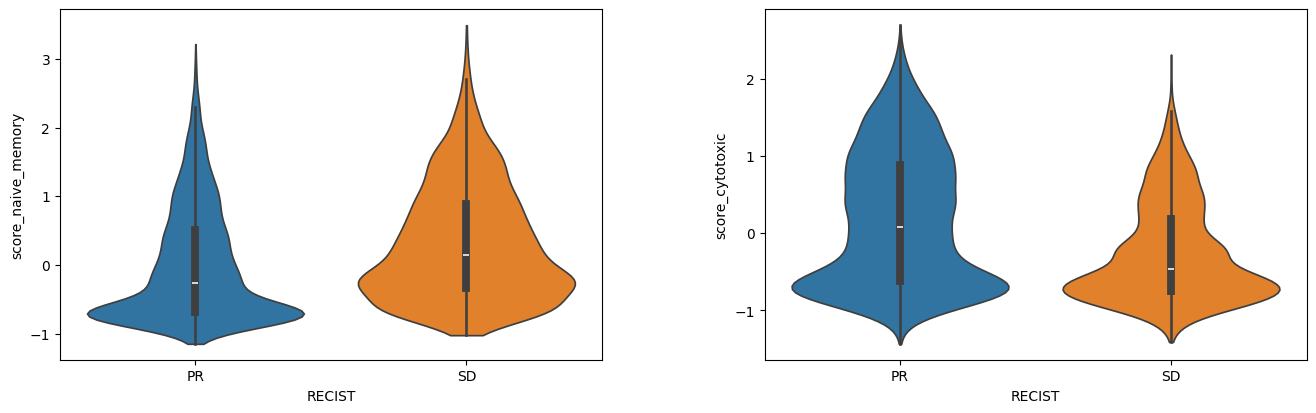

Saved: Results/Figures/Tcells_PR_vs_SD_naive_vs_cytotoxic_violin.png


In [18]:
# Zoom intra–T cells: Cytotoxic vs Naive/Memory programs (PR vs SD)

import scanpy as sc

# adata_t doit déjà exister (subset T cells)
# Scores déjà calculés:
# - score_naive_memory
# - score_cytotoxic

sc.pl.violin(
    adata_t,
    keys=["score_naive_memory", "score_cytotoxic"],
    groupby="RECIST",
    stripplot=False,
    inner="box",
    show=False
)

# Save figure
import matplotlib.pyplot as plt
plt.savefig("Results/Figures/Tcells_PR_vs_SD_naive_vs_cytotoxic_violin.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: Results/Figures/Tcells_PR_vs_SD_naive_vs_cytotoxic_violin.png")

In [29]:
# Proportions of dominant T-cell programs (PR vs SD)

import pandas as pd

score_df = adata_t.obs[["score_naive_memory", "score_cytotoxic", "score_exhaustion", "RECIST"]].copy()

score_df["dominant_state"] = score_df[["score_naive_memory", "score_cytotoxic", "score_exhaustion"]].idxmax(axis=1)
score_df["dominant_state"] = score_df["dominant_state"].map({
    "score_naive_memory": "Naive/Memory",
    "score_cytotoxic": "Cytotoxic",
    "score_exhaustion": "Checkpoint/Exhaustion",
})

# Proportions using crosstab (does not re-insert RECIST)
ct = pd.crosstab(score_df["RECIST"], score_df["dominant_state"], normalize="index")

# Long format for saving
prop_df = ct.stack().reset_index()
prop_df.columns = ["RECIST", "dominant_state", "fraction"]

prop_df.to_csv("Results/Tcell_dominant_state_proportions_PR_vs_SD.csv", index=False)
prop_df

,RECIST,dominant_state,fraction
0,PR,Checkpoint/Exhaustion,0.264935
1,PR,Cytotoxic,0.395584
2,PR,Naive/Memory,0.339481
3,SD,Checkpoint/Exhaustion,0.259748
4,SD,Cytotoxic,0.234518
5,SD,Naive/Memory,0.505734


CD8 genes used: ['CD8A', 'CD8B', 'NKG7', 'GNLY', 'PRF1', 'GZMB', 'GZMH', 'IFNG', 'CCL5']
CD4 genes used: ['IL7R', 'CCR7', 'LTB', 'SELL', 'TCF7', 'LEF1']


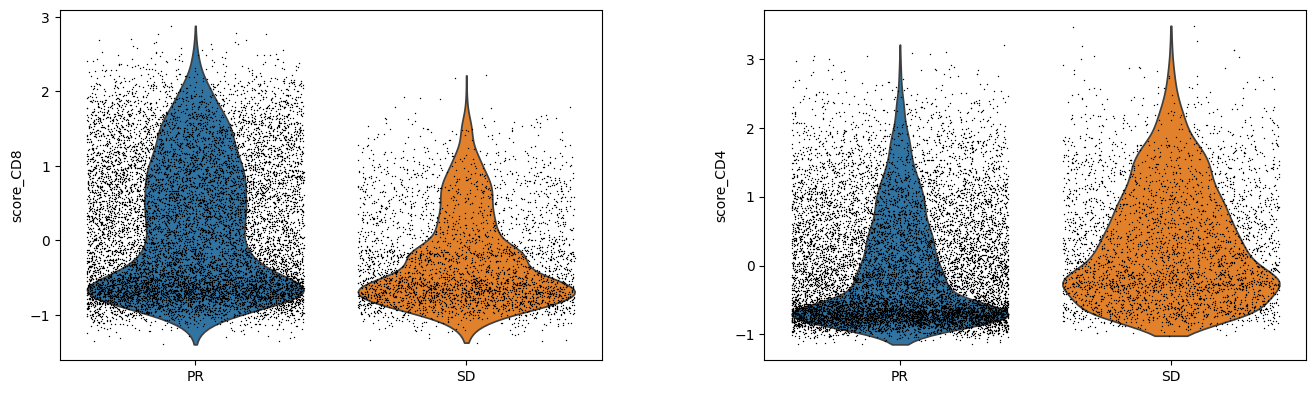

dominant_CD,RECIST,CD4-like,CD8-like
0,PR,0.463550,0.536450
1,SD,0.653096,0.346904


In [30]:
# Zoom CD8 vs CD4 within T cells (PR vs SD)

import scanpy as sc
import pandas as pd

# --- Gene sets (filtered to genes present) ---
present = set(adata_t.var_names)
def keep(g): return [x for x in g if x in present]

cd8_genes = keep(["CD8A","CD8B","NKG7","GNLY","PRF1","GZMB","GZMH","IFNG","CCL5"])
cd4_genes = keep(["IL7R","CCR7","LTB","SELL","TCF7","LEF1","CD4"])

print("CD8 genes used:", cd8_genes)
print("CD4 genes used:", cd4_genes)

# --- Score programs ---
sc.tl.score_genes(adata_t, cd8_genes, score_name="score_CD8")
sc.tl.score_genes(adata_t, cd4_genes, score_name="score_CD4")

# --- Violin plots (PR vs SD) ---
sc.pl.violin(
    adata_t,
    keys=["score_CD8", "score_CD4"],
    groupby="RECIST",
    jitter=0.4,
    rotation=0,
    save="_Tcells_CD8_vs_CD4_violin.png"
)

# --- Dominant CD8 vs CD4 per cell ---
df = adata_t.obs[["score_CD8","score_CD4","RECIST"]].copy()
df["dominant_CD"] = df[["score_CD8","score_CD4"]].idxmax(axis=1)
df["dominant_CD"] = df["dominant_CD"].map({
    "score_CD8": "CD8-like",
    "score_CD4": "CD4-like"
})

# --- Proportions ---
prop_cd = (
    pd.crosstab(df["RECIST"], df["dominant_CD"], normalize="index")
    .reset_index()
)

prop_cd.to_csv("Results/Tcell_CD8_vs_CD4_proportions_PR_vs_SD.csv", index=False)
prop_cd